## Part 0: Setting things up -- libraries and functions

### Loading needed libraries

In [127]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plotting functions

In [43]:
### Plotting the results
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize)/kernelSize, 'valid')
    return array

def plot_dqn(obj, title = 'DQN'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(311)
    plt.plot(convolve(obj.loss_vec, kernelSize=11)/11)
    plt.title(title+' loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(312)
    plt.plot(convolve(obj.loss_vec, kernelSize=111)/111)
    plt.title(title+' smoothed loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(313)
    plt.plot(np.array(obj.returns)[:,0],np.array(obj.returns)[:,1])
    plt.xlabel('timesteps'), plt.ylabel('return')
    plt.title(title+' training performance')
    plt.show()

def plot_dsr(obj, title='DSR'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(211)
    plt.plot(convolve(obj.loss_q_vec, kernelSize=111))
    plt.title(title+' loss')
    plt.ylabel('loss q value'), plt.xlabel('batch no')
    plt.subplot(212)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=111))
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def plot_dsr2(obj, title='DSR'):
    plt.figure(figsize=(12,4),dpi=100)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def params_count(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

### Sanity check functions

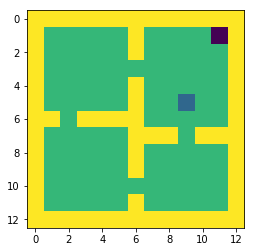

In [132]:
plt.imshow(env.render())

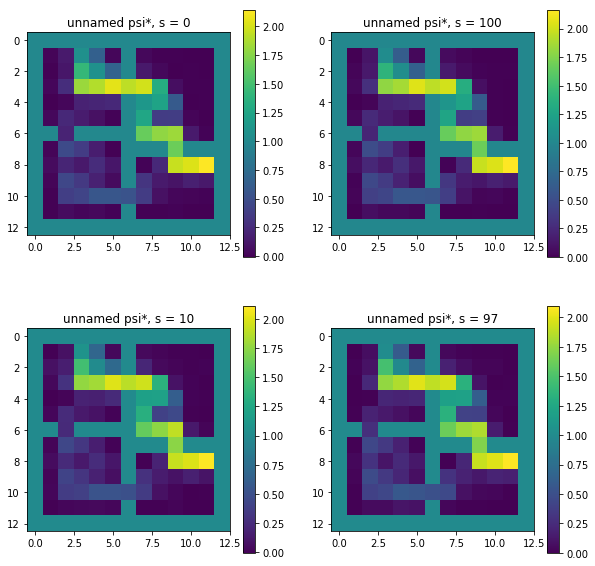

In [214]:
from deep_rl.component.fourrooms import FourRooms
env = FourRooms(goal=9)

def _visualize_vector(vector, title="unnamed", show_goal=False, show=True, label=None):
    """Function to visualize vector of size 104"""
    
    current_grid = np.array(env.occupancy, dtype=np.float) # 1 - walls, 0 - 
    for i in range(104):
    #     if(vals[i]>0):
    #         import pdb; pdb.set_trace()
        p_cell = env.tocell[i]
        current_grid[p_cell[0], p_cell[1]] = vector[i]

        if show_goal:
            goal_cell = env.tocell[env.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -1
        
    plt.imshow(current_grid), plt.colorbar()
    plt.title(title)
    if show:
        plt.show()
        
def sanity(agent, is_dsr=True, title="unnamed"):
    
    print(agent.network)
    plt.figure(figsize=(10,10))
    
    # Setting things up
    env = FourRooms(goal=9)
    
    # Visualize w
    if(is_dsr):
        plt.subplot(221)
        w_vector = agent.network.state_dict()['psi2q.w'].numpy()
        _visualize_vector(w_vector, title=title+" w learnt values", show=False)
    
    # Visualize psi
    if(is_dsr):
        plt.subplot(222)
        states = [100]
#         plt.figure(figsize=(len(states)*12, 5))

        for i, s in enumerate(states):
            temp = np.zeros(104)
            temp[s] = 1
            phi, psi, q = agent.network(tensor(temp).unsqueeze(0))
            psi = psi.detach().numpy()
            optimal_actions = q.max(1)[1].detach().numpy()
            psi = psi[:, optimal_actions, :]
            q = q.detach().numpy().flatten()
#             _visualize_vector(psi[:,0,:].flatten(), title=title+" q({},{})={}".format(s, 0, q[0]), show=False, label="0")
            _visualize_vector(psi.flatten(), title=title+" psi*, s = {}".format(s), show=False, label="1")
            
    # Visualize policy
    state_space = np.identity(104)
    if(is_dsr):
        
        phi, psi, q = agent.network(tensor(state_space))
    else:
        q = agent.network(tensor(state_space))
    
#     print('Qvalue estiamtes: ', q.detach().numpy())
    plt.subplot(223)
    optimal_actions = q.max(1)[1].detach().numpy()
#     import pdb; pdb.set_trace()
    _visualize_vector(optimal_actions, title=title+'policy (0:up,1:down,2:left,3:right)', show=False)
#     plt.show()
    plt.subplot(224)
    # Visualize Q*
    _visualize_vector(q.max(1)[0].detach().numpy(), title=title+' Q* estimates')
    
    return
  
def sanity_psi(dsr, action_net=None, states=[0, 100, 10, 97], title="unnamed"):
    """
    action_net needs to be a DQN or None for this funciton to work.
    """
    plt.figure(figsize=(10,10))
    state_space = np.identity(104)
    phi, psi, q = dsr.network(tensor(state_space))
    psi = psi.detach().numpy()
    if(action_net is not None):
        q = action_net.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    
    psi = psi[:, optimal_actions, :]

    for i, s in enumerate(states):
        plt.subplot(2,2,i+1)
        _visualize_vector(psi[s,:,:,].flatten(), title=title+" psi*, s = {}".format(s), show=False, label="1")
    return

sanity_psi(avdsr)
# sanity(avdsr, is_dsr=False, title='initDSR, f2')
# plot_dqn(dqn, title='initDSR, f2')
# dsr1 = dsr2
# print(dsr1.loss_psi_vec[:10],dsr1.loss_q_vec[:10])
# print(dsr1.loss_psi_vec[-10:],dsr1.loss_q_vec[-10:])

(104, 2)


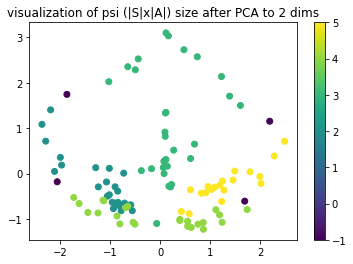

In [68]:
from sklearn.decomposition import PCA

def dimenRed(vis_agent):
    """
    Function to reduce the dimensionality of the psi(s,a) representations learnt,
    and visualizing them.
    """
    state_space = np.identity(104)
    c = np.ones(104)*5
    room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
    room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
    room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
    connect = [25, 51, 62, 88]
    c[room1] = 2
    c[room2] = 3
    c[room3] = 4
    c[connect] = -1
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    psi = psi.view(104,-1).detach().numpy()
    pca = PCA(n_components=2)
    k = pca.fit_transform(psi)
    print(k.shape)
    plt.scatter(k[:,0],k[:,1],c=c)
    plt.colorbar()
    plt.title('visualization of psi (|S|x|A|) size after PCA to 2 dims')
    
    
def dimenRed2(vis_agent, act_agent):
    """
    Function to reduce the dimensionality of the psi* representations learnt,
    and visualizing them.
    NOTE: psi*, where are the optimal actions picked from matters. act_agent 
    is used here.
    """
    state_space = np.identity(104)
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    
    if('DSR' in str(type(act_agent))):
        _, _, q = act_agent.network(tensor(state_space))
    else:
        q = act_agent.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    
    pass

dimenRed(avdsr)

### DSR training function

In [3]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1
#     config.freeze = False

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=())
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 0.1, 5e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    # Train an agent with the above config
    agent = DSRAgent(config)
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

### DQN training function

In [121]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
    return agent

## Part 1: Run basic DSR and DQN to confirm they learn the task

In [117]:
class Psi2QNetFC(nn.Module):
    def __init__(self, output_dim, feature_dim, hidden_units=(), gate=F.relu):
        super(Psi2QNetFC, self).__init__()

        dims = (feature_dim*output_dim,) + hidden_units + (output_dim,)
        self.layers = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.gate = gate
    
    def forward(self, psi):
        out = psi.view(psi.size(0), -1)
        for layer in self.layers[:-1]:
            out = self.gate(layer(out))
        out = self.layers[-1](out)
        return out

class SRNet(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(), gate=F.relu):
        super(SRNet, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        dims = (body.feature_dim,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.psi2q = Psi2QNetFC(output_dim, body.feature_dim)

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = self.psi2q(psi)

        return phi, psi, out

In [118]:
# dsr1 = dsr_feature(game='FourRooms-Goal-9', freeze=0)
# dsr2 = dsr_feature(game='FourRooms-Goal-9', freeze=1)
dqn = dqn_feature(game='FourRooms-Goal-9')

2020-04-24 14:40:26,467 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
Process AsyncReplay-75:
Traceback (most recent call last):
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/mnt/c/Users/Surya Penmetsa/Desktop/McGill Courses/Thesis/code/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [81]:
print(dqn.network.body)

FCBody(
  (layers): ModuleList(
    (0): Linear(in_features=104, out_features=16, bias=True)
  )
)


In [119]:
45348-1668

43680

In [120]:
params_count(dqn.network), params_count(initdsr1.network)

(45348, 45348)

Text(0.5,1,'DQN l')

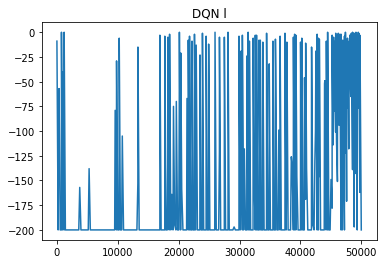

In [104]:
plt.plot(np.array(dqn.returns)[:,0],np.array(dqn.returns)[:,1])
plt.title('DQN l')

## Part 2: Train an avSR initialization 

In [21]:
def runNAgents(function, runs, store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRooms-Goal-9', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [ ]:
agents, _, _ = runNAgents(dqn_feature, runs=1, store=True)

In [310]:
def avdsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=()) #CHECK
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e6), batch_size=10)

    config.random_action_prob = LinearSchedule(0.2, 0.2, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [10]:
avdsr = avdsr_feature(game='FourRooms-Goal-9', agents=[dqn])

2020-04-24 13:34:40,342 - root - INFO: steps 0, 174762666.67 steps/s
2020-04-24 13:34:41,684 - root - INFO: steps 1000, 746.28 steps/s
2020-04-24 13:34:42,954 - root - INFO: steps 2000, 788.49 steps/s
2020-04-24 13:34:44,395 - root - INFO: steps 3000, 694.55 steps/s
2020-04-24 13:34:45,911 - root - INFO: steps 4000, 660.52 steps/s
2020-04-24 13:34:47,384 - root - INFO: steps 5000, 679.39 steps/s
2020-04-24 13:34:49,291 - root - INFO: steps 6000, 524.89 steps/s
2020-04-24 13:34:51,146 - root - INFO: steps 7000, 539.99 steps/s
2020-04-24 13:34:52,714 - root - INFO: steps 8000, 638.51 steps/s
2020-04-24 13:34:54,226 - root - INFO: steps 9000, 662.22 steps/s
2020-04-24 13:34:55,650 - root - INFO: steps 10000, 703.11 steps/s
2020-04-24 13:34:57,089 - root - INFO: steps 11000, 695.43 steps/s
2020-04-24 13:34:58,503 - root - INFO: steps 12000, 707.79 steps/s
2020-04-24 13:34:59,920 - root - INFO: steps 13000, 706.91 steps/s
2020-04-24 13:35:01,381 - root - INFO: steps 14000, 684.97 steps/s
20

Text(0.5,1,'unsupervised learning loss does go down')

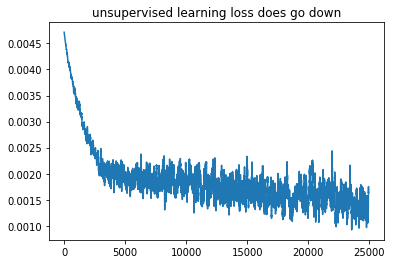

In [11]:
plt.plot(convolve(avdsr.loss_vec, 50))
plt.title('unsupervised learning loss does go down')

In [9]:
sanity(avdsr)

NameError: name 'sanity' is not defined

## Part 3: Train N agents of all styles on same environment and compare results

### SR with FC layer projections to estimate value

In [12]:
class SRNet(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(), gate=F.relu):
        super(SRNet, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        dims = (body.feature_dim,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.psi2q = Psi2QNetFC(output_dim, body.feature_dim)

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = self.psi2q(psi)

        return phi, psi, out

In [123]:
r_dqn3 = runNAgents(dqn_feature, 5)




runs:   0%|          | 0/5 [00:00<?, ?it/s]2020-04-24 14:41:36,396 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-24 14:41:41,545 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-04-24 14:41:46,233 - root - INFO: steps 10000, episodic_return_test -83.00(30.21)
2020-04-24 14:41:50,967 - root - INFO: steps 15000, episodic_return_test -84.30(29.88)
2020-04-24 14:41:55,580 - root - INFO: steps 20000, episodic_return_test -25.90(18.39)
2020-04-24 14:42:00,284 - root - INFO: steps 25000, episodic_return_test -11.50(1.78)
2020-04-24 14:42:05,226 - root - INFO: steps 30000, episodic_return_test -12.60(1.24)
2020-04-24 14:42:10,086 - root - INFO: steps 35000, episodic_return_test -7.70(1.26)
2020-04-24 14:42:15,274 - root - INFO: steps 40000, episodic_return_test -8.30(1.59)
2020-04-24 14:42:20,784 - root - INFO: steps 45000, episodic_return_test -7.20(1.14)
2020-04-24 14:42:28,654 - root - INFO: steps 50000, episodic_return_test -7.00(1.43)



runs:  20

In [22]:
# r_dsr1 = runNAgents(dsr_feature, 10, freeze=0)
# r_dsr2 = runNAgents(dsr_feature, 10, freeze=1)
# r_dqn = runNAgents(dqn_feature, 10)
# r_avdsr1 = runNAgents(dsr_feature_init, 1, freeze=1, ref=avdsr)
# r_avdsr = runNAgents(dsr_feature_init, 10, freeze=1, ref=avdsr)
r_avdsr = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr)

runs:   0%|          | 0/5 [00:00<?, ?it/s]2020-04-24 13:41:51,479 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-24 13:41:57,392 - root - INFO: steps 5000, episodic_return_test -180.60(18.40)
2020-04-24 13:42:02,739 - root - INFO: steps 10000, episodic_return_test -8.10(1.34)
2020-04-24 13:42:08,282 - root - INFO: steps 15000, episodic_return_test -10.60(1.69)
2020-04-24 13:42:13,978 - root - INFO: steps 20000, episodic_return_test -10.00(1.75)
2020-04-24 13:42:21,069 - root - INFO: steps 25000, episodic_return_test -12.20(1.27)
2020-04-24 13:42:27,907 - root - INFO: steps 30000, episodic_return_test -25.60(18.40)
2020-04-24 13:42:34,341 - root - INFO: steps 35000, episodic_return_test -6.50(1.44)
2020-04-24 13:42:40,771 - root - INFO: steps 40000, episodic_return_test -46.40(24.34)
2020-04-24 13:42:47,150 - root - INFO: steps 45000, episodic_return_test -10.80(1.91)
2020-04-24 13:42:53,663 - root - INFO: steps 50000, episodic_return_test -7.60(1.32)
runs:  20%|██ 

  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [20]:
initdsr2 = dsr_feature_init(game='FourRooms-Goal-9', ref=avdsr, freeze=2)

2020-04-24 13:39:34,130 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-24 13:39:39,928 - root - INFO: steps 5000, episodic_return_test -122.30(30.10)
2020-04-24 13:39:45,406 - root - INFO: steps 10000, episodic_return_test -26.50(18.35)
2020-04-24 13:39:51,124 - root - INFO: steps 15000, episodic_return_test -66.30(27.71)
2020-04-24 13:39:57,203 - root - INFO: steps 20000, episodic_return_test -46.50(24.31)
2020-04-24 13:40:03,624 - root - INFO: steps 25000, episodic_return_test -7.50(1.58)
2020-04-24 13:40:10,279 - root - INFO: steps 30000, episodic_return_test -9.60(1.10)
2020-04-24 13:40:19,826 - root - INFO: steps 35000, episodic_return_test -25.60(18.40)
2020-04-24 13:40:28,325 - root - INFO: steps 40000, episodic_return_test -7.20(1.42)
2020-04-24 13:40:36,111 - root - INFO: steps 45000, episodic_return_test -9.40(1.84)
2020-04-24 13:40:43,761 - root - INFO: steps 50000, episodic_return_test -7.80(1.99)
Process AsyncReplay-11:
Traceback (most recent call last)

In [17]:
initdsr1 = dsr_feature_init(game='FourRooms-Goal-9', ref=avdsr, freeze=1)

2020-04-24 13:38:07,316 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-24 13:38:15,482 - root - INFO: steps 5000, episodic_return_test -83.30(30.14)
2020-04-24 13:38:23,153 - root - INFO: steps 10000, episodic_return_test -102.00(30.99)
Process AsyncReplay-7:
Traceback (most recent call last):
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/mnt/c/Users/Surya Penmetsa/Desktop/McGill Courses/Thesis/code/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
sanity(initdsr1)
plot_dqn(initdsr1)

In [19]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [ ]:
last1 = runNAgents(dsr_feature_init, 1, freeze=True, ref=agent)

In [125]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6))
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = np.interp(np.arange(clip), t, r)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(), plt.show()

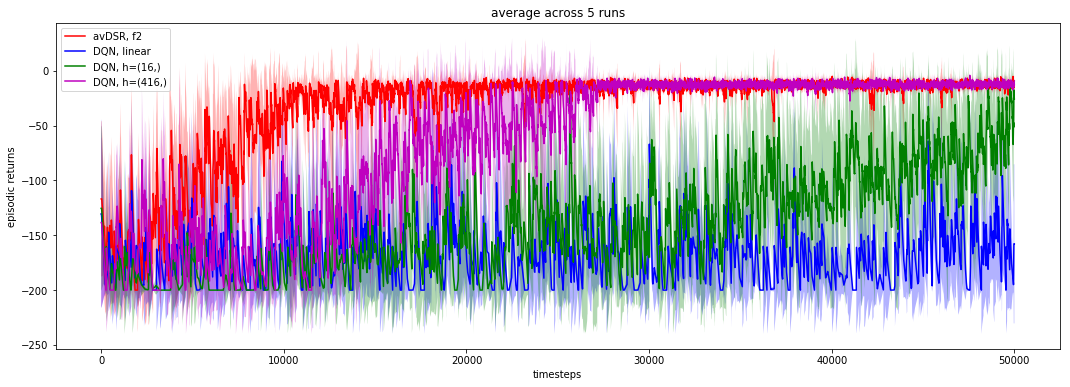

In [295]:
rewards_dict = {'avDSR, f2': r_avdsr, 'DQN, linear': r_dqn, 'DQN, h=(16,)': r_dqn2, 'DQN, h=(416,)': r_dqn3}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='average across 5 runs')

## Transfer experiments
1. Train DQN on 3 random tasks
2. Learn avDSR init by taking actions from DQN
3. Train avDSR (freeze=2) 

(another idea on 2 -- instead of picking an agent each timestep, pick an agent each episode -- this makes more sense for me intuitively)

[37 12 72  9]


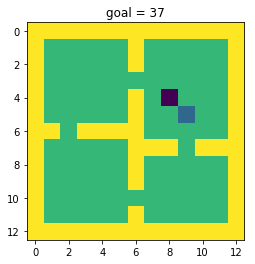

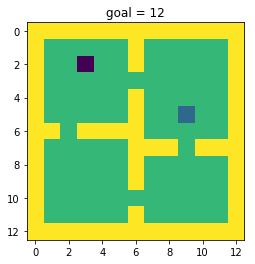

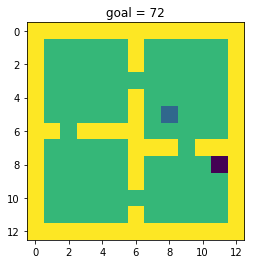

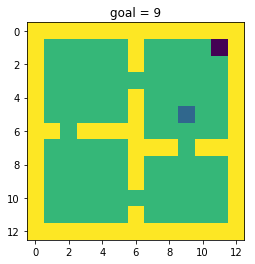

In [301]:
np.random.seed(1)
goal_locs = np.random.choice(104, 4)
goal_locs[3] = 9
print(goal_locs)
for i in range(4):
    env = FourRooms(goal=goal_locs[i])
    env.reset()
    plt.imshow(env.render())
    plt.title('goal = ' + str(goal_locs[i]))
    plt.show()

In [138]:
dqn1 = dqn_feature(game='FourRooms-Goal-'+str(goal_locs[0]))
dqn2 = dqn_feature(game='FourRooms-Goal-'+str(goal_locs[1]))
dqn3 = dqn_feature(game='FourRooms-Goal-'+str(goal_locs[2]))

2020-04-24 15:14:43,819 - root - INFO: steps 0, episodic_return_test -180.10(18.88)
2020-04-24 15:14:48,372 - root - INFO: steps 5000, episodic_return_test -81.60(30.57)
2020-04-24 15:14:52,731 - root - INFO: steps 10000, episodic_return_test -121.40(30.44)
2020-04-24 15:14:56,918 - root - INFO: steps 15000, episodic_return_test -43.80(24.70)
2020-04-24 15:15:01,099 - root - INFO: steps 20000, episodic_return_test -5.80(0.73)
2020-04-24 15:15:05,280 - root - INFO: steps 25000, episodic_return_test -6.80(1.40)
2020-04-24 15:15:09,635 - root - INFO: steps 30000, episodic_return_test -6.40(0.97)
2020-04-24 15:15:14,374 - root - INFO: steps 35000, episodic_return_test -5.40(1.03)
2020-04-24 15:15:22,583 - root - INFO: steps 40000, episodic_return_test -6.70(1.08)
2020-04-24 15:15:29,276 - root - INFO: steps 45000, episodic_return_test -9.30(0.86)
2020-04-24 15:15:34,881 - root - INFO: steps 50000, episodic_return_test -5.60(1.34)
2020-04-24 15:15:35,439 - root - INFO: steps 0, episodic_ret

In [140]:
# Printing network to ensure we're training the correct one
print(dqn1.network)
print(params_count(dqn1.network))

VanillaNet(
  (fc_head): Linear(in_features=416, out_features=4, bias=True)
  (body): FCBody(
    (layers): ModuleList(
      (0): Linear(in_features=104, out_features=416, bias=True)
    )
  )
)
45348


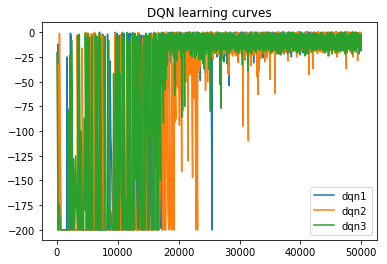

In [163]:
# Plot DQN learning curves to ensure learning
plt.plot(np.array(dqn1.returns)[:,0],np.array(dqn1.returns)[:,1], label='dqn1')
plt.plot(np.array(dqn2.returns)[:,0],np.array(dqn2.returns)[:,1], label='dqn2')
plt.plot(np.array(dqn3.returns)[:,0],np.array(dqn3.returns)[:,1], label='dqn3')
plt.title('DQN learning curves'), plt.legend()
plt.show()

VanillaNet(
  (fc_head): Linear(in_features=416, out_features=4, bias=True)
  (body): FCBody(
    (layers): ModuleList(
      (0): Linear(in_features=104, out_features=416, bias=True)
    )
  )
)


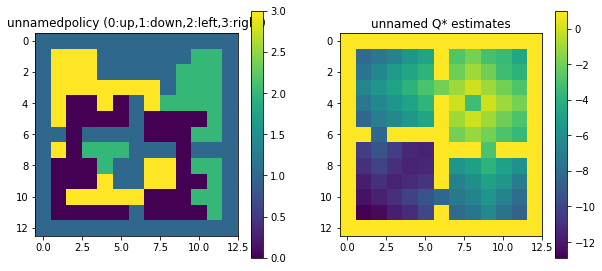

In [166]:
sanity(dqn1, is_dsr=False)

In [311]:
# Learn avDSR agent
avdsr = avdsr_feature(game='FourRooms-Goal-9', agents=[dqn1, dqn2, dqn3])

2020-04-25 19:21:01,746 - root - INFO: steps 0, 167772160.00 steps/s
2020-04-25 19:21:03,132 - root - INFO: steps 1000, 727.22 steps/s
2020-04-25 19:21:04,562 - root - INFO: steps 2000, 701.06 steps/s
2020-04-25 19:21:06,165 - root - INFO: steps 3000, 625.66 steps/s
2020-04-25 19:21:07,556 - root - INFO: steps 4000, 722.00 steps/s
2020-04-25 19:21:08,816 - root - INFO: steps 5000, 796.87 steps/s
2020-04-25 19:21:10,072 - root - INFO: steps 6000, 799.27 steps/s
2020-04-25 19:21:11,344 - root - INFO: steps 7000, 789.80 steps/s
2020-04-25 19:21:12,684 - root - INFO: steps 8000, 748.39 steps/s
2020-04-25 19:21:14,175 - root - INFO: steps 9000, 672.91 steps/s
2020-04-25 19:21:15,438 - root - INFO: steps 10000, 794.95 steps/s
2020-04-25 19:21:16,646 - root - INFO: steps 11000, 831.06 steps/s
2020-04-25 19:21:17,851 - root - INFO: steps 12000, 832.65 steps/s
2020-04-25 19:21:19,282 - root - INFO: steps 13000, 706.09 steps/s
2020-04-25 19:21:20,880 - root - INFO: steps 14000, 627.52 steps/s
20

Text(0.5,1,'h=(,)')

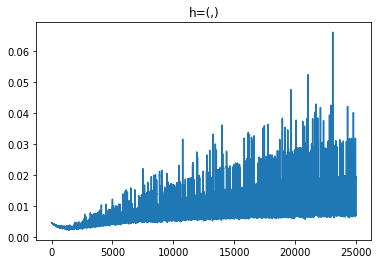

In [312]:
# plot DSR loss to ensure learning
plt.plot(convolve(avdsr.loss_vec, 10))
plt.title('h=(,)')

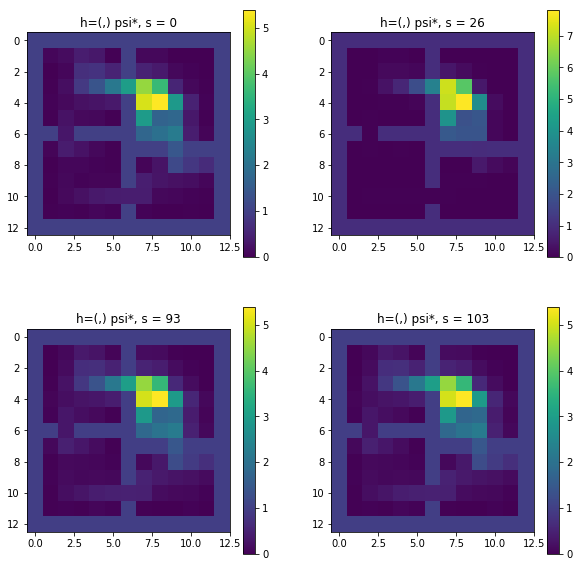

In [315]:
sanity_psi(avdsr, states=[0,26,93,103], title='h=(,)')
# sanity_psi(avdsr, action_net=dqn1, states=[0,26,97,103], title='h=(,)')

In [307]:
# Learn agents based on DSR avDSR on the new task
def runNAgents(function, runs, goal=9,store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRooms-Goal-'+str(goal), freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [316]:
r_avdsr_transfer_dqn = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr)




runs:   0%|          | 0/5 [00:00<?, ?it/s]2020-04-25 19:26:48,340 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-25 19:26:54,235 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-04-25 19:27:01,169 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-04-25 19:27:07,047 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-04-25 19:27:13,413 - root - INFO: steps 20000, episodic_return_test -200.00(0.00)
2020-04-25 19:27:20,812 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-04-25 19:27:28,015 - root - INFO: steps 30000, episodic_return_test -200.00(0.00)
2020-04-25 19:27:36,665 - root - INFO: steps 35000, episodic_return_test -200.00(0.00)
2020-04-25 19:27:45,000 - root - INFO: steps 40000, episodic_return_test -200.00(0.00)
2020-04-25 19:27:53,042 - root - INFO: steps 45000, episodic_return_test -200.00(0.00)
2020-04-25 19:28:01,377 - root - INFO: steps 50000, episodic_return_test -200.00(0.00)




OSError: [Errno 24] Too many open files

In [308]:
r_avdsr_transfer_eps = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr)




runs:   0%|          | 0/5 [00:00<?, ?it/s]2020-04-25 19:11:17,693 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-25 19:11:23,480 - root - INFO: steps 5000, episodic_return_test -103.20(30.62)
2020-04-25 19:11:29,645 - root - INFO: steps 10000, episodic_return_test -102.90(30.71)
2020-04-25 19:11:34,607 - root - INFO: steps 15000, episodic_return_test -44.30(24.67)
2020-04-25 19:11:39,993 - root - INFO: steps 20000, episodic_return_test -7.10(1.01)
2020-04-25 19:11:47,111 - root - INFO: steps 25000, episodic_return_test -10.00(1.54)
2020-04-25 19:11:56,785 - root - INFO: steps 30000, episodic_return_test -126.30(28.55)
2020-04-25 19:12:06,228 - root - INFO: steps 35000, episodic_return_test -9.20(1.52)
2020-04-25 19:12:15,416 - root - INFO: steps 40000, episodic_return_test -11.50(1.78)
2020-04-25 19:12:24,057 - root - INFO: steps 45000, episodic_return_test -12.30(1.29)
2020-04-25 19:12:33,309 - root - INFO: steps 50000, episodic_return_test -8.00(1.32)



runs:

In [318]:
rewards_dict = {'avDSR, f2 (random init)': r_avdsr_transfer_eps, 'avDSR, f2 (DQNinit-37,12,72)': r_avdsr_transfer_dqn,
                'DQN, linear': r_dqn, 'DQN, h=(16,)': r_dqn2, 'DQN, h=(416,)': r_dqn3}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='average across 5 runs (env: FourRooms9)')
print('NOTE: unspervised exploration has been done on the same environment')

NameError: name 'r_avdsr_transfer_dqn' is not defined

In [319]:
a = 0
b = 1
for i in range(10):
    a, b = b, a+b
    print(b)

1
2
3
5
8
13
21
34
55
89
